<a href="https://www.kaggle.com/code/mohdmuttalib/otto-eda?scriptVersionId=181198898" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# OTTO EDA


## Load libraries

In [1]:
import random
from collections import Counter
from datetime import timedelta
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
sns.set_style("darkgrid")
warnings.simplefilter("ignore")

## Load data

It looks like pretty big dataset, so let's load it in chunks

In [3]:
chunksize = 20_000

train_data = pd.read_json("../input/otto-recommender-system/train.jsonl", lines=True, chunksize=chunksize)
test_data = pd.read_json("../input/otto-recommender-system/test.jsonl", lines=True, chunksize=chunksize)
sample_submission = pd.read_csv("../input/otto-recommender-system/sample_submission.csv", chunksize=chunksize)

Let's examine number of sessions in train and test

In [4]:
with open('../input/otto-recommender-system/train.jsonl', 'r') as f:
    print(f"Train: {len(f.readlines()):,} lines")
with open('../input/otto-recommender-system/test.jsonl', 'r') as f:
    print(f"Test {len(f.readlines()):,} lines")

Train: 12,899,779 lines
Test 1,671,803 lines


As it expected, dataset is realy big. So let's load the first chunk of data to examine structure of the datset

In [5]:
train_data_chunk = train_data.__next__()
train_data_chunk

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."
3,3,"[{'aid': 1425967, 'ts': 1659304800095, 'type':..."
4,4,"[{'aid': 613619, 'ts': 1659304800119, 'type': ..."
...,...,...
19995,19995,"[{'aid': 1481519, 'ts': 1659305842045, 'type':..."
19996,19996,"[{'aid': 1109584, 'ts': 1659305842183, 'type':..."
19997,19997,"[{'aid': 1647277, 'ts': 1659305842315, 'type':..."
19998,19998,"[{'aid': 753948, 'ts': 1659305842328, 'type': ..."


Let's look at events of some session

In [6]:
train_data_chunk.iloc[112]["events"]

[{'aid': 1556453, 'ts': 1659304801664, 'type': 'clicks'},
 {'aid': 1556453, 'ts': 1659304804055, 'type': 'carts'},
 {'aid': 1572879, 'ts': 1659304918252, 'type': 'clicks'},
 {'aid': 1374838, 'ts': 1659304929527, 'type': 'clicks'},
 {'aid': 1374838, 'ts': 1659304937453, 'type': 'clicks'},
 {'aid': 199865, 'ts': 1659304969527, 'type': 'clicks'},
 {'aid': 1567940, 'ts': 1659341229359, 'type': 'clicks'},
 {'aid': 51798, 'ts': 1659341236788, 'type': 'clicks'},
 {'aid': 693625, 'ts': 1659465963886, 'type': 'clicks'},
 {'aid': 693625, 'ts': 1659466437047, 'type': 'clicks'},
 {'aid': 1828810, 'ts': 1659466493303, 'type': 'clicks'},
 {'aid': 1014210, 'ts': 1659466552636, 'type': 'clicks'},
 {'aid': 1001000, 'ts': 1659466605871, 'type': 'clicks'},
 {'aid': 1528969, 'ts': 1659466620637, 'type': 'clicks'},
 {'aid': 500582, 'ts': 1659466664246, 'type': 'clicks'},
 {'aid': 28010, 'ts': 1659466683724, 'type': 'clicks'},
 {'aid': 1017261, 'ts': 1659466861733, 'type': 'clicks'},
 {'aid': 1545215, 'ts':

As we see, data has the next structure:
- session - the unique id of session
- events - ordered events, that happened in this session. Each event consists of:
    - aid - the article id (product code) of the associated event
    - ts - the Unix timestamp of the event (in microseconds)
    - type - the event type ("clicks", "carts", "orders"). Whether a product was clicked, added to the user's cart, or ordered during the session

## Extract data to work with

Because full dataset is big, let's get a few chunks to perform analysis on

In [7]:
indices = [i for i in range(100)]
random.shuffle(indices)
indices = indices[:3]
print(f"Chunks chosen: {indices}")

chunks_of_train = []
for idx, chunk in enumerate(train_data):
    if idx in indices:
        chunks_of_train.append(chunk)
    if idx > max(indices):
        break

chunks_of_train = pd.concat(chunks_of_train)
chunks_of_train

Chunks chosen: [78, 95, 23]


,session,events
480000,480000,"[{'aid': 1084758, 'ts': 1659352409015, 'type':..."
480001,480001,"[{'aid': 1448923, 'ts': 1659352409063, 'type':..."
480002,480002,"[{'aid': 477066, 'ts': 1659352409152, 'type': ..."
480003,480003,"[{'aid': 6526, 'ts': 1659352409165, 'type': 'c..."
480004,480004,"[{'aid': 1147322, 'ts': 1659352409174, 'type':..."
...,...,...
1939995,1939995,"[{'aid': 1841845, 'ts': 1659464082841, 'type':..."
1939996,1939996,"[{'aid': 651841, 'ts': 1659464082849, 'type': ..."
1939997,1939997,"[{'aid': 740254, 'ts': 1659464082887, 'type': ..."
1939998,1939998,"[{'aid': 1343718, 'ts': 1659464082955, 'type':..."


Now we may transform dataset to csv format

In [8]:
events_dict = {
    "session": [],
    "aid": [],
    "ts": [],
    "type": [],
}

for _, row in chunks_of_train.iterrows():
    for event in row["events"]:
        events_dict["session"].append(row["session"])
        events_dict["aid"].append(event["aid"])
        events_dict["ts"].append(event["ts"])
        events_dict["type"].append(event["type"])

train_part = pd.DataFrame(events_dict)
train_part

,session,aid,ts,type
0,480000,1084758,1659352409015,clicks
1,480000,859697,1659352522844,clicks
2,480001,1448923,1659352409063,clicks
3,480001,1448923,1659352716778,clicks
4,480001,1805622,1659535544338,clicks
...,...,...,...,...
1777979,1939999,293213,1661628694908,clicks
1777980,1939999,293213,1661628694909,clicks
1777981,1939999,293213,1661629134614,clicks
1777982,1939999,293213,1661629139699,carts


## Analysis

First of all, let's calculate number of sessions and events in this dataset

In [9]:
n_sessions = train_part["session"].nunique()
n_events = train_part.shape[0]

print(f"Number of sessions: {n_sessions}")
print(f"Number of events: {n_events}")
print(f"Mean number of events in session: {n_events/n_sessions}")

Number of sessions: 60000
Number of events: 1777984
Mean number of events in session: 29.633066666666668


Let's dig into relation of numbers of events and sessions

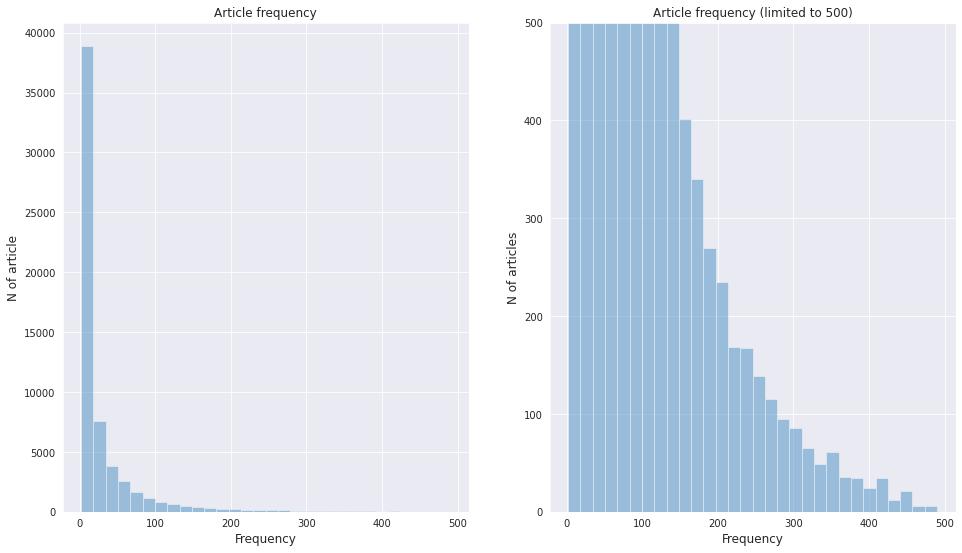

In [10]:
events_in_session = train_part.groupby(['session'])['aid'].count().sort_values(ascending=False)

fig, ax = plt.subplots(ncols=2, figsize=(16, 9))
sns.distplot(x=events_in_session.values, ax=ax[0], bins=30, kde=False)
ax[0].set_title('Article frequency', fontsize=12)
ax[0].set_ylabel('N of article', fontsize=12)
ax[0].set_xlabel('Frequency', fontsize=12)

sns.distplot(x=events_in_session.values, ax=ax[1], bins=30, kde=False)
ax[1].set_title('Article frequency (limited to 500)', fontsize=12)
ax[1].set_ylabel('N of articles', fontsize=12)
ax[1].set_xlabel('Frequency', fontsize=12)
ax[1].set_ylim(0, 500)

plt.show()

Seems like most of the articles has been opened just a few times

Now let's compare, how often every type of event occured

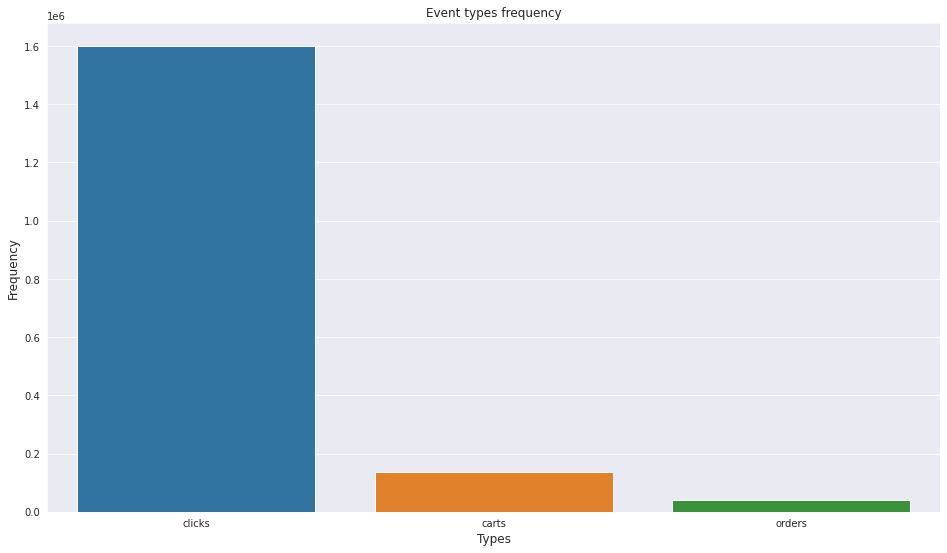

In [11]:
events_types = train_part.groupby(['type'])['type'].count().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x=events_types.index, y=events_types.values, ax=ax)
ax.set_title('Event types frequency', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Types', fontsize=12)
plt.show()

Clicks occured much more often, then carts and orders. But this events are more important to predict due to competition metric

In [12]:
def count_seconds(x):
    max_value = int(x.max())
    min_value = int(x.min())
    session_time = timedelta(microseconds=max_value - min_value)
    return session_time.total_seconds() / 60 

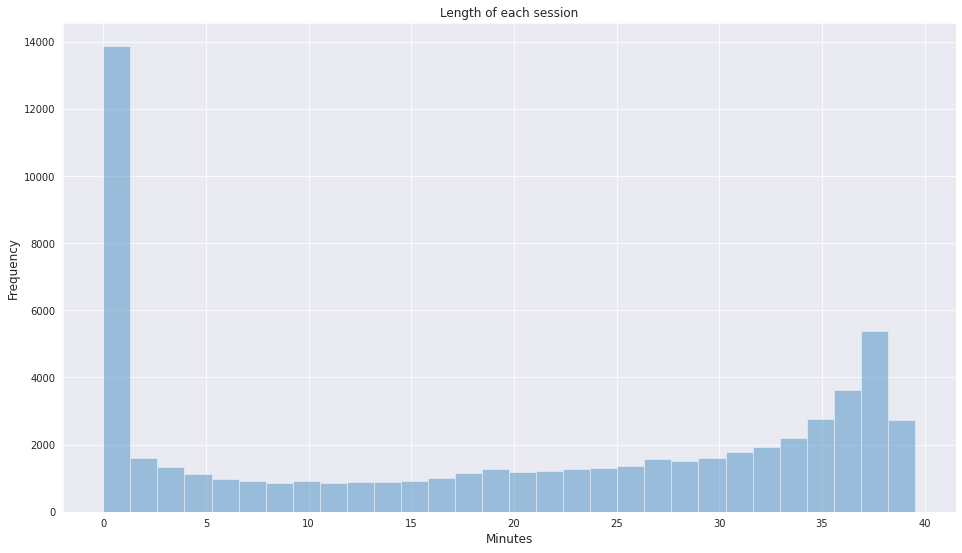

In [13]:
time_counts = train_part.groupby(['session'])['ts'].apply(count_seconds)
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=time_counts.values, ax=ax, bins=30, kde=False)
ax.set_title('Length of each session', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Minutes', fontsize=12)
plt.show()

Finaly, let's visualize number of actions, performed in each session

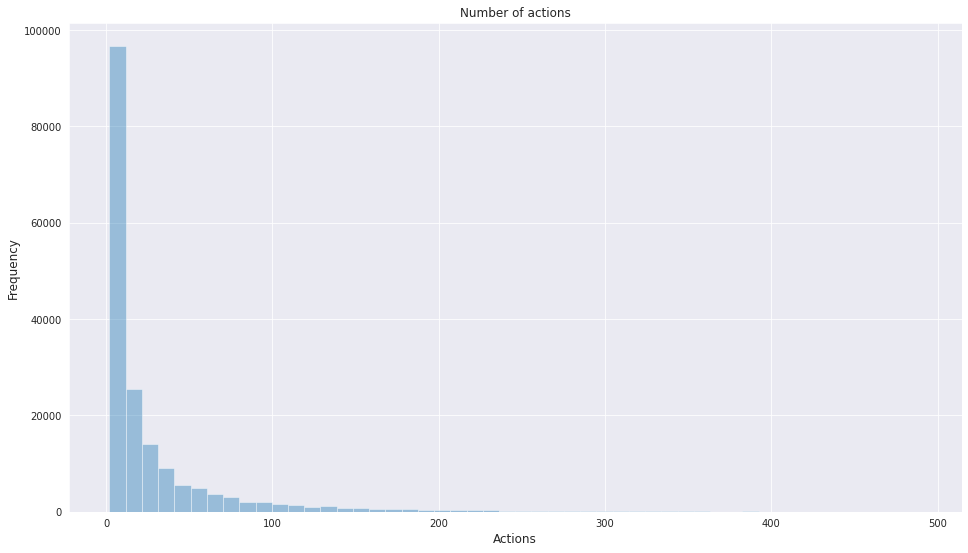

In [14]:
event_types_in_session = train_part.groupby(['session']).count()
fig, ax = plt.subplots(figsize=(16, 9))
sns.distplot(x=event_types_in_session.values, ax=ax, bins=50, kde=False)
ax.set_title('Number of actions', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_xlabel('Actions', fontsize=12)
plt.show()

Finally, I want to test, whether users who order something has longer sessions and more events

In [15]:
order_in_session = train_part.groupby(['session']).apply(lambda x: x['type'].eq("orders").any())
order_in_session

session
480000     False
480001      True
480002     False
480003     False
480004     False
           ...  
1939995    False
1939996    False
1939997    False
1939998    False
1939999    False
Length: 60000, dtype: bool

In [16]:
combined_data = pd.concat([event_types_in_session["aid"], time_counts, order_in_session], axis=1)
combined_data

,aid,ts,0
session,,,
480000,2,0.001897,False
480001,7,3.056305,True
480002,25,36.629321,False
480003,24,14.582902,False
480004,11,0.005776,False
...,...,...,...
1939995,2,3.953133,False
1939996,2,0.000332,False
1939997,30,28.958685,False


In [17]:
print(f"Mean time spend by users who order: {combined_data.loc[combined_data[0] == True]['ts'].mean()}")
print(f"Mean time spend by users who didn't order: {combined_data.loc[combined_data[0] == False]['ts'].mean()}")

Mean time spend by users who order: 27.263262026931443
Mean time spend by users who didn't order: 17.48965562885969


In [18]:
print(f"Mean time spend by users who order: {combined_data.loc[combined_data[0] == True]['aid'].mean()}")
print(f"Mean time spend by users who didn't order: {combined_data.loc[combined_data[0] == False]['aid'].mean()}")

Mean time spend by users who order: 78.01305767138194
Mean time spend by users who didn't order: 18.738381115739607


Seems like users who order spend more time and perform more actions